In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import transforms, datasets
from torch.autograd import Variable

In [2]:
print(torch.__version__)

1.8.0


# TUTORIAL - **[PyTorch Training a Classifier](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py)**

In [3]:
# normalize
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# download training dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
# assign num workers and create batchsize using torch dataloader
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)
# class labels
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [12]:
trainset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [13]:
testset

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

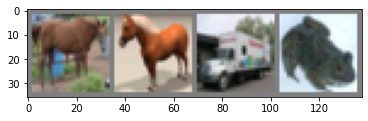

horse horse truck  frog


In [4]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
        
net = Net()

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [19]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 0.898
[1,  4000] loss: 0.909
[1,  6000] loss: 0.943
[1,  8000] loss: 0.968
[1, 10000] loss: 0.970
[1, 12000] loss: 0.958
[2,  2000] loss: 0.867
[2,  4000] loss: 0.886
[2,  6000] loss: 0.878
[2,  8000] loss: 0.903
[2, 10000] loss: 0.915
[2, 12000] loss: 0.930
Finished Training


In [20]:
# save model
PATH = './saved_models/stock_model.pt'
torch.save(net.state_dict(), PATH)

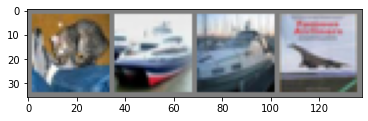

GroundTruth:    cat  ship  ship plane


In [21]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [22]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [23]:
outputs = net(images)

In [24]:
_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat  ship plane plane


In [25]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 63 %


In [26]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 69 %
Accuracy of   car : 79 %
Accuracy of  bird : 51 %
Accuracy of   cat : 39 %
Accuracy of  deer : 43 %
Accuracy of   dog : 61 %
Accuracy of  frog : 75 %
Accuracy of horse : 69 %
Accuracy of  ship : 78 %
Accuracy of truck : 62 %


# CONTRIBUTION

### BATCH SIZE = 32
### TESTLOADER SHUFFEL = TRUE

In [3]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=16, shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=16, shuffle=True, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

### SETTING TO TRAIN THE MODEL USING GPU

In [5]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

Running on the GPU


### DISPLAYING IMAGES IN ONE BATCH

torch.Size([16, 3, 32, 32])
torch.Size([16])


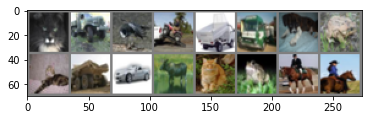

  cat truck  bird truck truck truck   dog  frog   cat truck   car  deer   cat  frog horse horse


In [6]:
def imshow(img):
    img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(images.shape)
print(labels.shape)
# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(16)))

In [7]:
# model 2_layers

class Model_a(nn.Module):
    def __init__(self):
        super(Model_a, self).__init__()
        self.network = nn.Sequential(
            # Conv Layer block 1
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

            # Conv Layer block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8
            
            nn.Flatten(), 
            nn.Linear(128*8*8, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1),
            nn.Linear(512, 10))

    def forward(self, x):
        return self.network(x)
    
layer_2_model = Model_a().to(device)

In [8]:
total = 0
print('Trainable parameters:')
for name, param in layer_2_model.named_parameters():
    if param.requires_grad:
        print(name, '\t', param.numel())
        total += param.numel()
print()
print('Total', '\t', total)

Trainable parameters:
network.0.weight 	 864
network.0.bias 	 32
network.2.weight 	 18432
network.2.bias 	 64
network.5.weight 	 73728
network.5.bias 	 128
network.7.weight 	 147456
network.7.bias 	 128
network.11.weight 	 8388608
network.11.bias 	 1024
network.14.weight 	 524288
network.14.bias 	 512
network.17.weight 	 5120
network.17.bias 	 10

Total 	 9160394


In [ ]:
# model 2_layers

class Model_b(nn.Module):
    def __init__(self):
        super(Model_a, self).__init__()
        self.network = nn.Sequential(
            # Conv Layer block 1
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

            # Conv Layer block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8
            
            # Conv Layer block 2
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4
            
            nn.Flatten(), 
            nn.Linear(128*8*8, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1),
            nn.Linear(512, 10))

    def forward(self, x):
        return self.network(x)
    
layer_2_model = Model_a().to(device)

In [9]:
def fit(epochs, learning_rate, model):
    history = []
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    for epoch in range(epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        epoch_loss = 0.0
        train_loss = []
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            # wrap them in Variable
            inputs, labels = Variable(inputs), Variable(labels)

            

            # forward + backward + optimize
            outputs = layer_2_model(inputs)
            
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            # zero the parameter gradients
            optimizer.zero_grad()
            
            epoch_loss += outputs.shape[0] * loss.item()

            # print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0
                
        # print epoch loss
        print(epoch+1, epoch_loss / len(trainset))
        train_loss.append(epoch_loss / len(trainset))

    print('Finished Training')

In [11]:
fit(3, 0.01, layer_2_model)

[1,  2000] loss: 1.229
1 1.1512418447875976
[2,  2000] loss: 0.818
2 0.7988523700857163
[3,  2000] loss: 0.577
3 0.5870085353696346
Finished Training


In [7]:
# defining the model architecture

class Net(nn.Module):   
    def __init__(self):
        super(Net, self).__init__()
        self.conv_layer = nn.Sequential(
            # Conv Layer block 1
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv Layer block 2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.05),

            # Conv Layer block 3
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.fc_layer = nn.Sequential(
            nn.Dropout(p=0.1),
            nn.Linear(4096, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1),
            nn.Linear(512, 10)
        )


    def forward(self, x):
        """Perform forward."""

        # conv layers
        x = self.conv_layer(x)

        # flatten
        x = x.view(x.size(0), -1)

        # fc layer
        x = self.fc_layer(x)

        return x

net = Net().to(device)

In [ ]:
for epoch in range(15):

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        
        inputs = inputs.to(device)
        labels = labels.to(device)

        # wrap them in Variable
        inputs, labels = Variable(inputs), Variable(labels)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()

#         if epoch > 16:
#             for group in optimizer.param_groups:
#                 for p in group['params']:
#                     state = optimizer.state[p]
#                     if state['step'] >= 1024:
#                         state['step'] = 1000
        optimizer.step() 
        running_loss += loss.item()
        
    # print statistics
    running_loss /= len(trainloader)
    print("Iteration: {0} | Loss: {1}".format(epoch, running_loss))
    running_loss = 0.0

print('==> Finished Training ...')

In [13]:
PATH = './saved_models/layer_2_model.pt'
torch.save(layer_2_model.state_dict(), PATH)

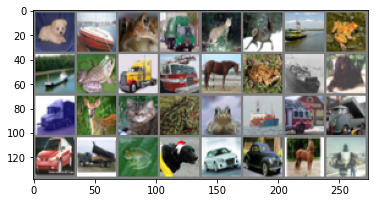

GroundTruth:    dog  ship  frog truck


In [12]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [16]:
layer_2_model = Model_a().to(device)
layer_2_model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [17]:
outputs = net(images)

NameError: name 'net' is not defined

In [15]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    dog  ship   cat truck


In [18]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = layer_2_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 73 %


In [21]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 79 %
Accuracy of   car : 96 %
Accuracy of  bird : 62 %
Accuracy of   cat : 64 %
Accuracy of  deer : 85 %
Accuracy of   dog : 71 %
Accuracy of  frog : 79 %
Accuracy of horse : 86 %
Accuracy of  ship : 89 %
Accuracy of truck : 87 %
